<a name='imports'>

# 2 <span style='color:blue'>|</span> Importing & Setup

In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

C:\Users\jms\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jms\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\jms\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)


***
<a name='import_data'>
    
# 3 <span style='color:blue'>|</span> Importing Data

In [3]:
# Function for inporting data           
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels


In [4]:

# Setting up file paths for training and testing
USER_PATH =  r'C:\Users\jms\OneDrive\Desktop\Major 1\CodeBrain\models\decdata2/'
train_dir =  r'C:\Users\jms\OneDrive\Desktop\Major 1\CodeBrain\models\decdata2\Training/'
test_dir =   r'C:\Users\jms\OneDrive\Desktop\Major 1\CodeBrain\models\decdata2\Testing/'
# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


***

<a name='vis'>
    
# 4 <span style='color:blue'>|</span> Data Visualization
    
## <b> 4.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Data Distributions <b>

A balanced distribution of categories in our training data is crucial for optimal model learning. It allows for comprehensive understanding of each category's characteristics, prevents biases, enhances generalization, and enables iterative refinement, leading to improved performance in accurately categorizing new data.

We also have a nice split percentage in our training and testing set.

x reshaped: (1, 150, 150, 3)


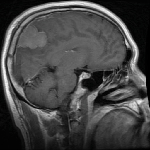

In [ ]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

***
<a name='DP'>
    
# 5 <span style='color:blue'>|</span> Data Processing & Training Setup Values 

In [6]:
# Image size
image_size = (150,150)

# Training batch size
batch_size = 32

In [7]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator =tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                    image_size=image_size,
                                                    batch_size=batch_size,
                                                    label_mode="categorical",
                                                    
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                  image_size=image_size,
                                                  batch_size=batch_size,
                                                  label_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


### <b> 5.1.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'> Data Augmentation Class Indices <b>

### <b> 5.1.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Showing Data Augmentation <b>

In [8]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """
    
    # Generate augmented samples
    augmented_samples = train_generator.next()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        
    plt.tight_layout()
        
    if save:
        plt.savefig('show_ImageDataGenerator.pdf')
        
    plt.show()


## <b> 5.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'> Training Setup Values <b>

In [9]:
#Defining CallBack list
from tensorflow.keras import callbacks
callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
def cnn_model(input_shape=(150, 150, 3), num_classes=4):
    inputs = Input(shape=input_shape, name="Input_layer") 
    # Convolutional layer 1
    conv1= Conv2D(32, (4, 4), activation="relu")(inputs)
    pool1 = MaxPooling2D(pool_size=(3, 3))(conv1)

    # Convolutional layer 2
    conv2 = Conv2D(64, (4, 4), activation="relu")(pool1)
    pool2 = MaxPooling2D(pool_size=(3, 3))(conv2)

    # Convolutional layer 3
    pool3 = MaxPooling2D(pool_size=(3, 3))(pool2)

    # Convolutional layer 4
    conv3 = Conv2D(128, (4, 4), activation="relu")(pool3)
    conv4 = Flatten()(conv3)

    # Fully connected layers
    conv5 = Dense(512, activation="relu")(conv4)
    conv6 = Dropout(0.5)(conv5)
    outputs= Dense(num_classes, activation="softmax")(conv6)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model
seed = 44

In [11]:

from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Dense, Flatten

base_model = cnn_model()

# Apply GlobalAveragePooling2D after one of the convolutional layers in the base model
x = base_model.layers[-5].output  # Output before the last convolutional layer


# Additional layers on top of the base model
x = Conv2D(32, 3, padding='same', activation='relu', name='Top_Conv_Layer')(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(4, activation='softmax', name='Output_layer')(x)

# Create the final model
Model_1 = tf.keras.Model(inputs=base_model.input, outputs=outputs)







## <b> 8.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Training Model <b>

In [12]:
test_loss, test_accuracy = Model_1.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [13]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [14]:
#Compile the model 
from tensorflow.keras import backend as K
Model_1.compile(
    loss = tf.keras.losses.categorical_crossentropy ,#--> Multiclass classification
    optimizer = tf.keras.optimizers.Adam() , #--> Adam optimizer with Learning_rate = 0.001
    metrics = ['accuracy', iou_coef, dice_coef]
)


#Fitting the model for 5 epochs 

Model_1_History = Model_1.fit(train_generator 
                              , validation_data = test_generator ,
                              epochs = 5  ,
                              verbose = 1 ,
                              callbacks = callback_list)

Epoch 1/5
179/179 [==============================] - 353s 2s/step - loss: 1.2377 - accuracy: 0.5903 - iou_coef: 0.7793 - dice_coef: 0.7988 - val_loss: 0.6731 - val_accuracy: 0.7460 - val_iou_coef: 0.8490 - val_dice_coef: 0.8644 - lr: 0.0010
Epoch 2/5
179/179 [==============================] - 339s 2s/step - loss: 0.5021 - accuracy: 0.8197 - iou_coef: 0.8721 - dice_coef: 0.8896 - val_loss: 0.4794 - val_accuracy: 0.8291 - val_iou_coef: 0.8866 - val_dice_coef: 0.9003 - lr: 0.0010
Epoch 3/5
179/179 [==============================] - 319s 2s/step - loss: 0.3627 - accuracy: 0.8717 - iou_coef: 0.9068 - dice_coef: 0.9210 - val_loss: 0.3996 - val_accuracy: 0.8520 - val_iou_coef: 0.9104 - val_dice_coef: 0.9220 - lr: 0.0010
Epoch 4/5
179/179 [==============================] - 317s 2s/step - loss: 0.2692 - accuracy: 0.8997 - iou_coef: 0.9282 - dice_coef: 0.9399 - val_loss: 0.4940 - val_accuracy: 0.8162 - val_iou_coef: 0.9076 - val_dice_coef: 0.9175 - lr: 0.0010
Epoch 5/5
179/179 [=================

In [15]:
#Define the function to plot loss and accuracy curves of train - valid 
def plot_loss_curves(history):
    train_loss = history.history["loss"]
    val_loss = history.history['val_loss']
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    #Plot Loss
    plt.plot(epochs , train_loss , label = "Train Loss")
    plt.plot(epochs , val_loss , label = "Val Loss" )
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #Plot accuracy
    plt.figure()
    plt.plot(epochs ,train_accuracy , label = "train_accuracy")
    plt.plot(epochs , val_accuracy , label = "val_accuracy" )
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

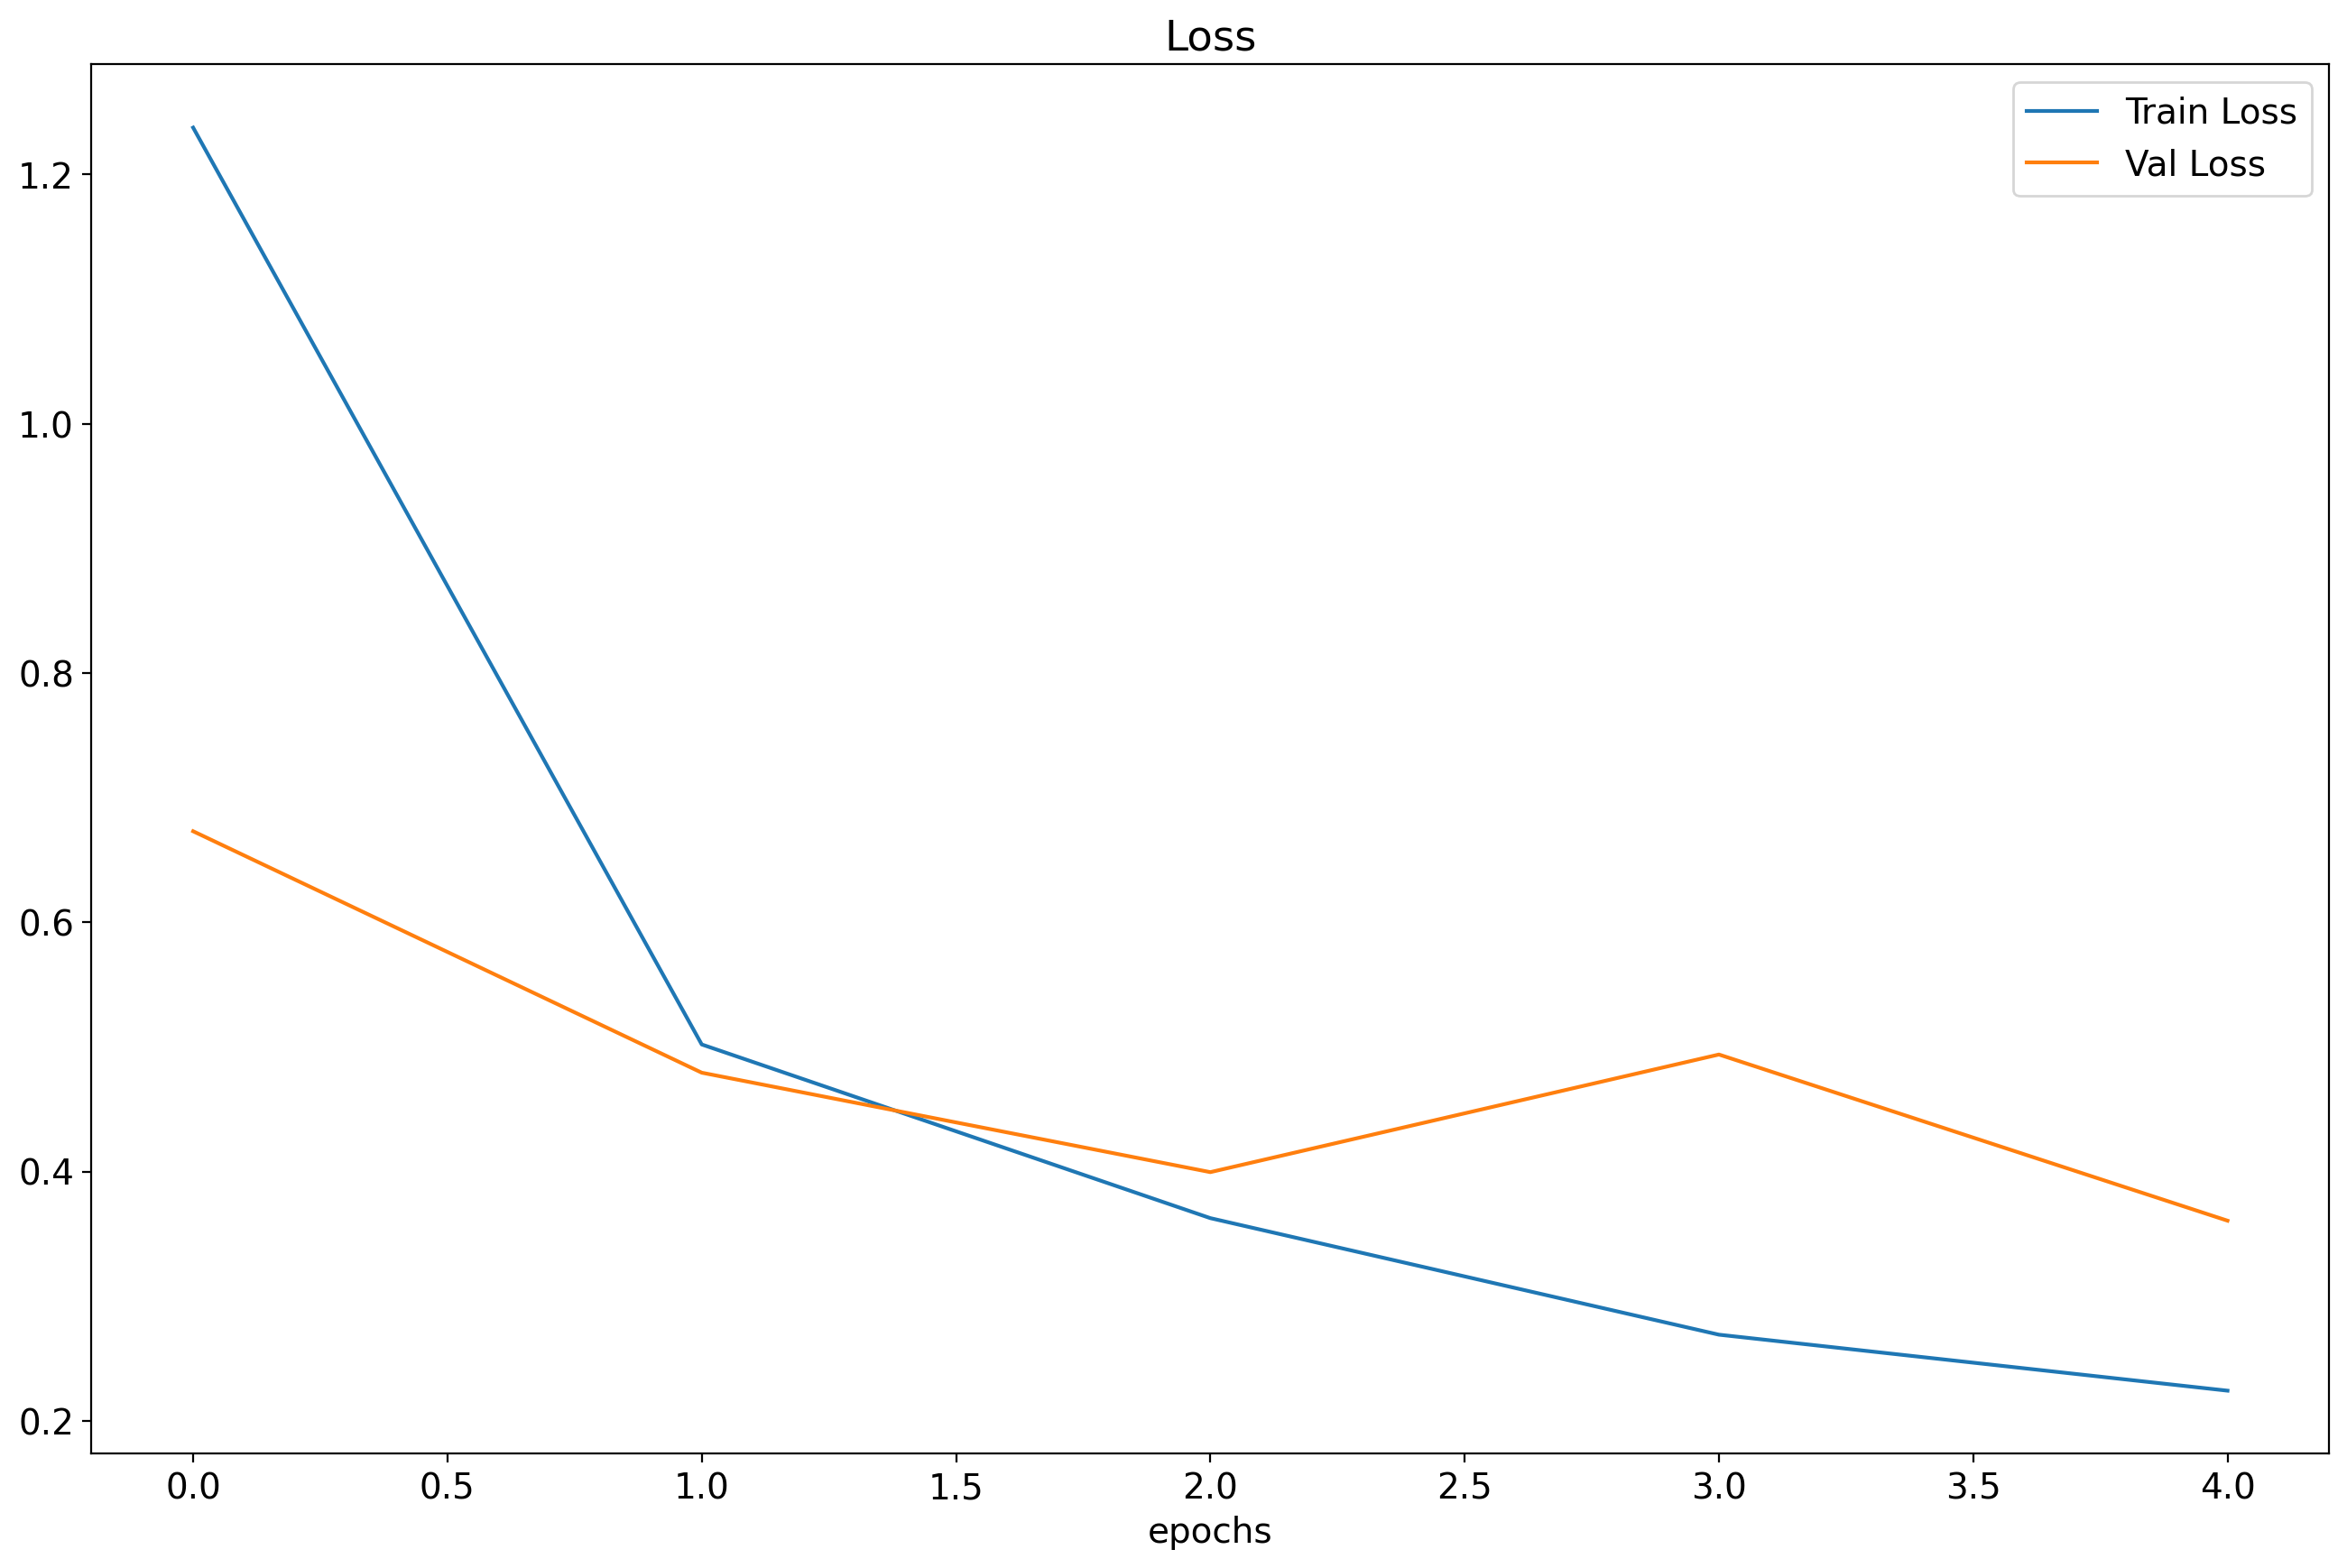

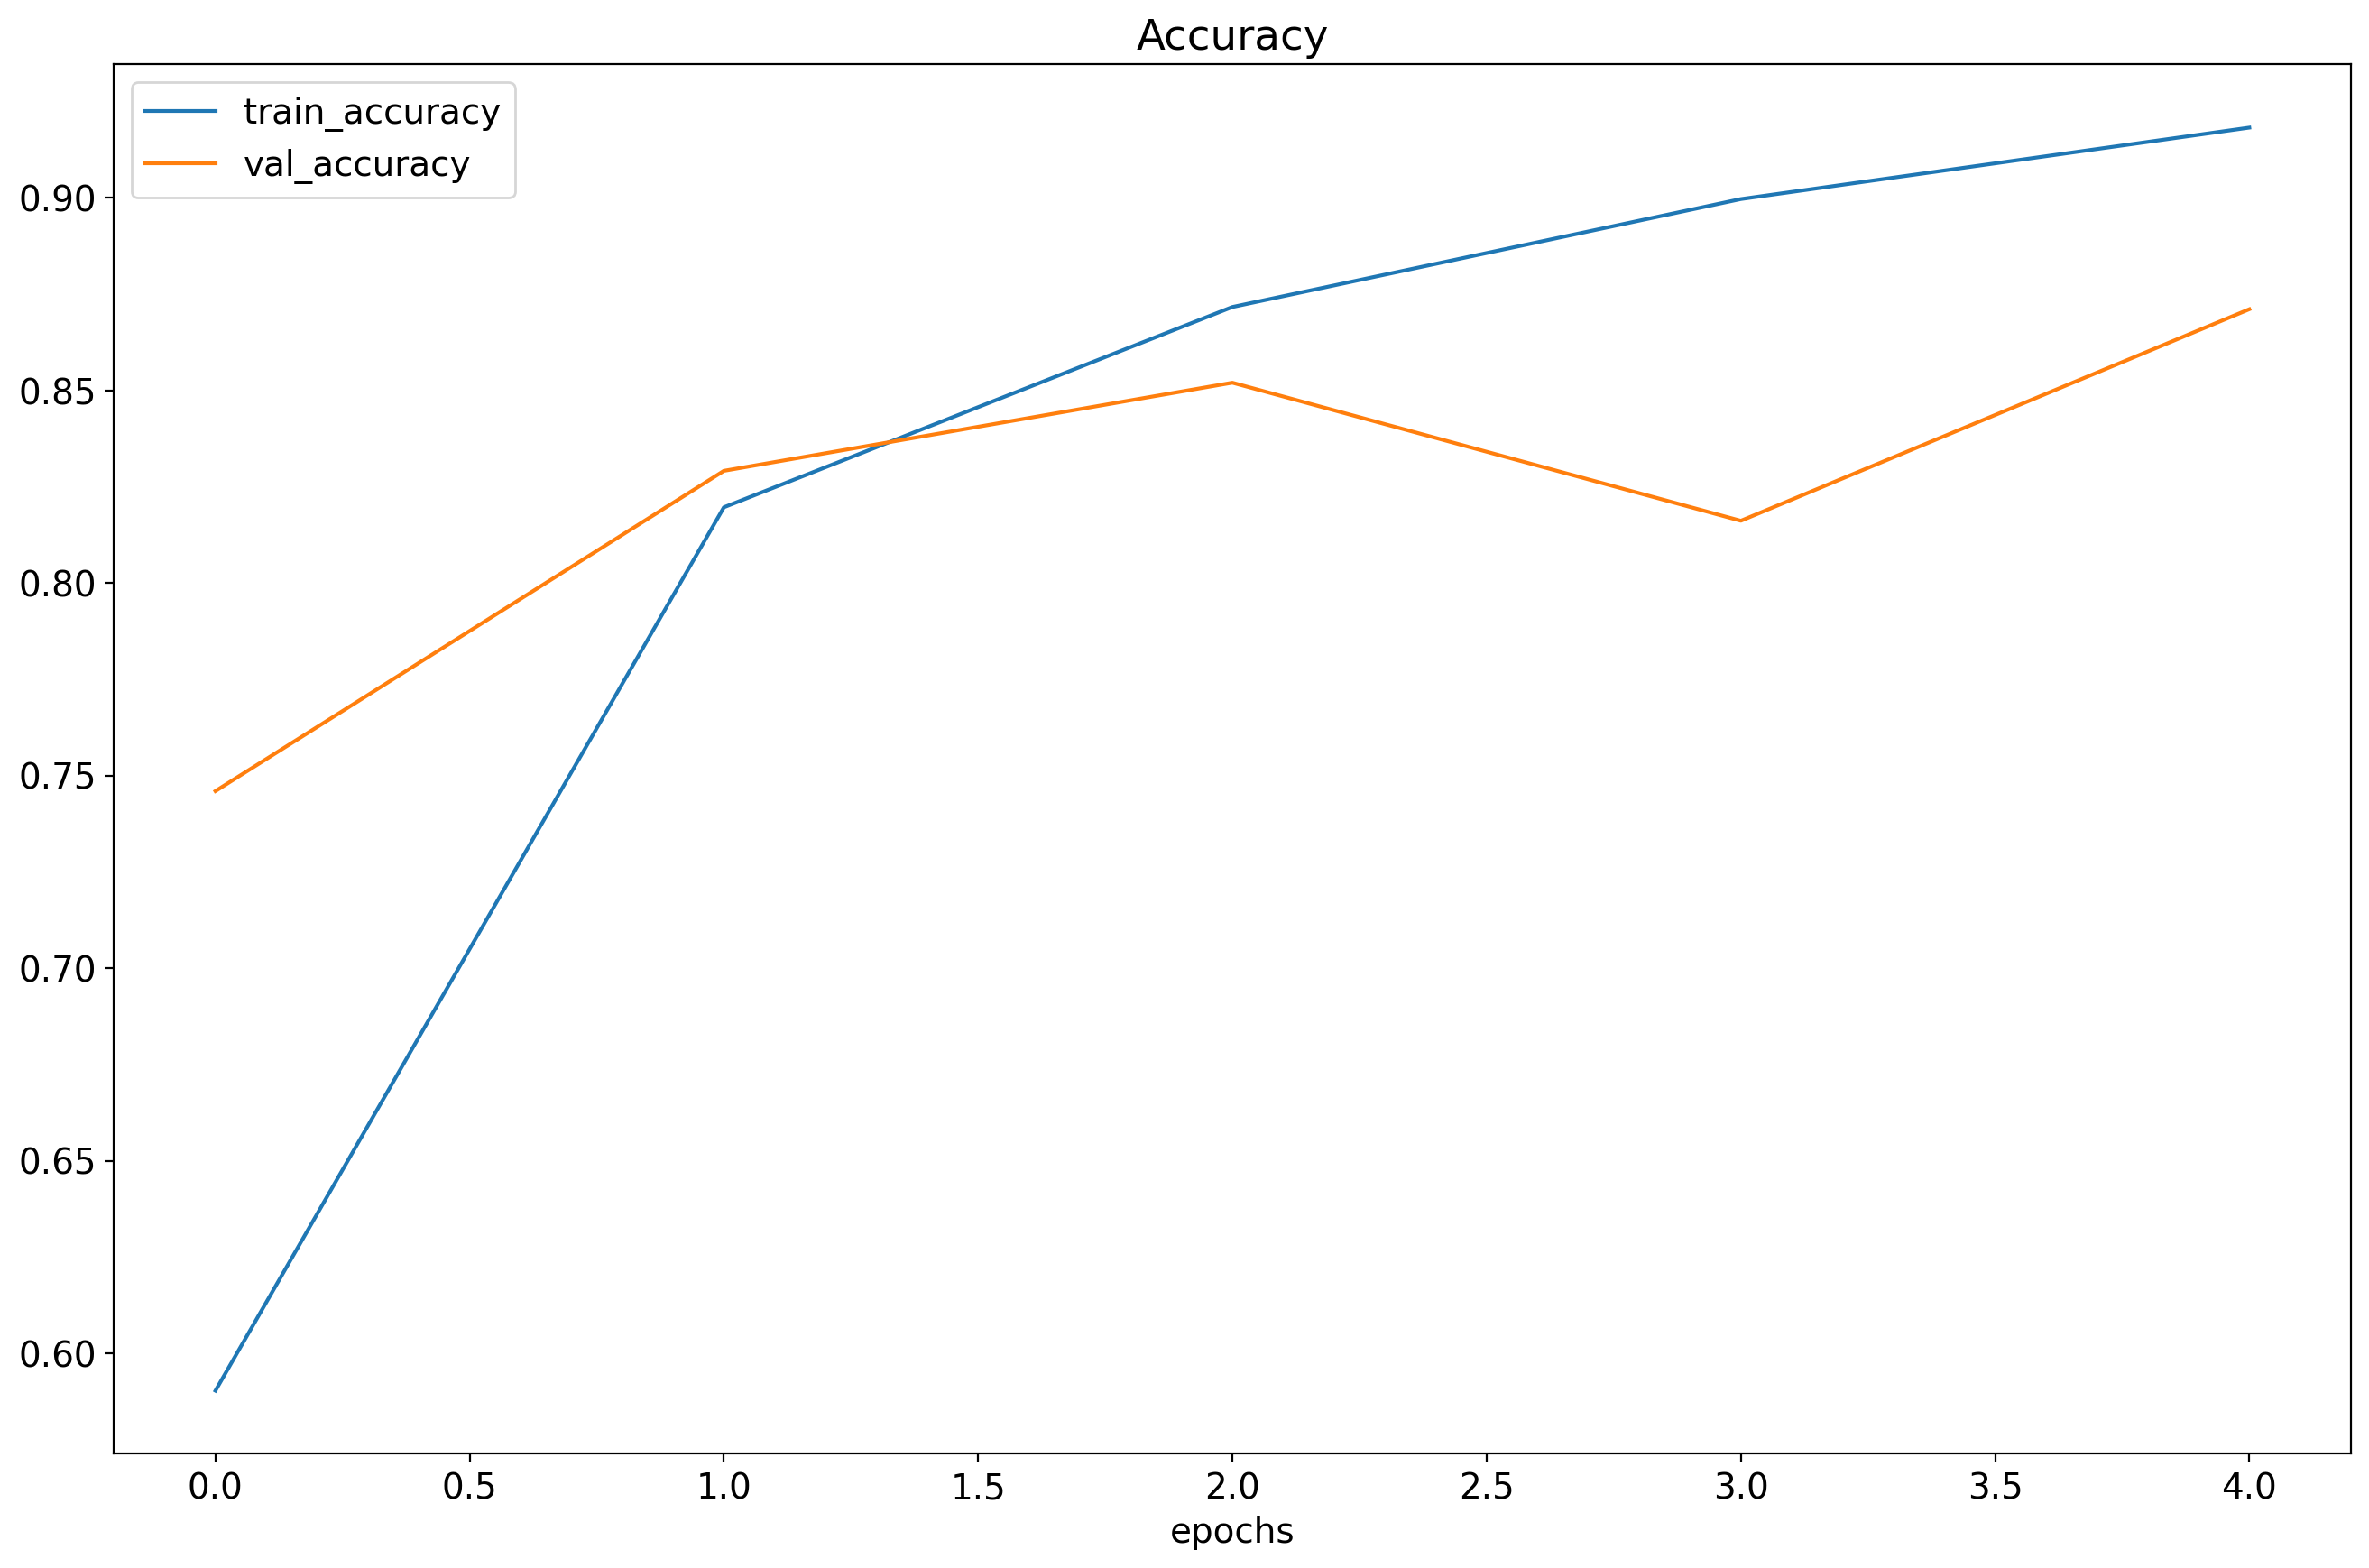

In [16]:
plot_loss_curves(Model_1_History)

In [17]:
# Un freaze all the Base_model 
base_model.trainable = True

#Freezing all the layers except last 10 
for layer in base_model.layers[:-10]:
    layer.trainable = False


#ReCompile the model 
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001), #--< When FineTuning u want to lower the LR by 10x
                metrics = ['accuracy', iou_coef, dice_coef]
               )


#FineTune for 10 epochs 
initial_epoch = 5

Fine_Tune_epoch = initial_epoch + 5

#Refit the model 
Stage_2_history = Model_1.fit(train_generator ,
                              epochs = Fine_Tune_epoch , 
                              validation_data =  test_generator ,
                              validation_steps = len( test_generator) ,
                              initial_epoch = initial_epoch-1)

Epoch 5/10
179/179 [==============================] - 332s 2s/step - loss: 0.1067 - accuracy: 0.9608 - iou_coef: 0.9667 - dice_coef: 0.9727 - val_loss: 0.2321 - val_accuracy: 0.9191 - val_iou_coef: 0.9495 - val_dice_coef: 0.9570
Epoch 6/10
179/179 [==============================] - 313s 2s/step - loss: 0.0778 - accuracy: 0.9722 - iou_coef: 0.9743 - dice_coef: 0.9790 - val_loss: 0.2214 - val_accuracy: 0.9222 - val_iou_coef: 0.9527 - val_dice_coef: 0.9599
Epoch 7/10
179/179 [==============================] - 325s 2s/step - loss: 0.0617 - accuracy: 0.9790 - iou_coef: 0.9788 - dice_coef: 0.9827 - val_loss: 0.2115 - val_accuracy: 0.9298 - val_iou_coef: 0.9566 - val_dice_coef: 0.9632
Epoch 8/10
179/179 [==============================] - 328s 2s/step - loss: 0.0478 - accuracy: 0.9876 - iou_coef: 0.9827 - dice_coef: 0.9859 - val_loss: 0.2040 - val_accuracy: 0.9321 - val_iou_coef: 0.9592 - val_dice_coef: 0.9654
Epoch 9/10
179/179 [==============================] - 333s 2s/step - loss: 0.0372 - 

In [18]:
#ReCompile the model and reduce Learning rate by 10x
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001), #--< lower the LR by 10x
                 metrics = ['accuracy', iou_coef, dice_coef]
               )
initial_epoch = 10
Fine_Tune_epoch = initial_epoch + 1
#Refit the model for 2 more epochs
Stage_2_history = Model_1.fit(train_generator ,
                              epochs = Fine_Tune_epoch , 
                              validation_data = test_generator ,
                              validation_steps = len(test_generator) ,
                              initial_epoch = initial_epoch-1)

Epoch 10/11
179/179 [==============================] - 325s 2s/step - loss: 0.0202 - accuracy: 0.9968 - iou_coef: 0.9918 - dice_coef: 0.9934 - val_loss: 0.2015 - val_accuracy: 0.9344 - val_iou_coef: 0.9631 - val_dice_coef: 0.9688
Epoch 11/11
179/179 [==============================] - 309s 2s/step - loss: 0.0187 - accuracy: 0.9968 - iou_coef: 0.9923 - dice_coef: 0.9938 - val_loss: 0.2039 - val_accuracy: 0.9344 - val_iou_coef: 0.9633 - val_dice_coef: 0.9690


In [19]:
#Define Some Functions :
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.image as img
last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size = (150,150)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model = Model_1 , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
           # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
 # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if view :
        display(Image(cam_path))
def decode_predictions(preds):
    classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction



def make_prediction (img_path , model = Model_1 , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(150,150))
    preds = Model_1.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]     

In [20]:
# Evaluate the model with test_generator
evaluation = Model_1.evaluate(test_generator)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])
print("Test IoU:", evaluation[2])
print("Test Dice:", evaluation[3])

41/41 [==============================] - 20s 468ms/step - loss: 0.2039 - accuracy: 0.9344 - iou_coef: 0.9633 - dice_coef: 0.9690
Test Loss: 0.20385946333408356
Test Accuracy: 0.9344012141227722
Test IoU: 0.9632881879806519
Test Dice: 0.9690088629722595


1/1 [==============================] - 2s 2s/step
meningioma


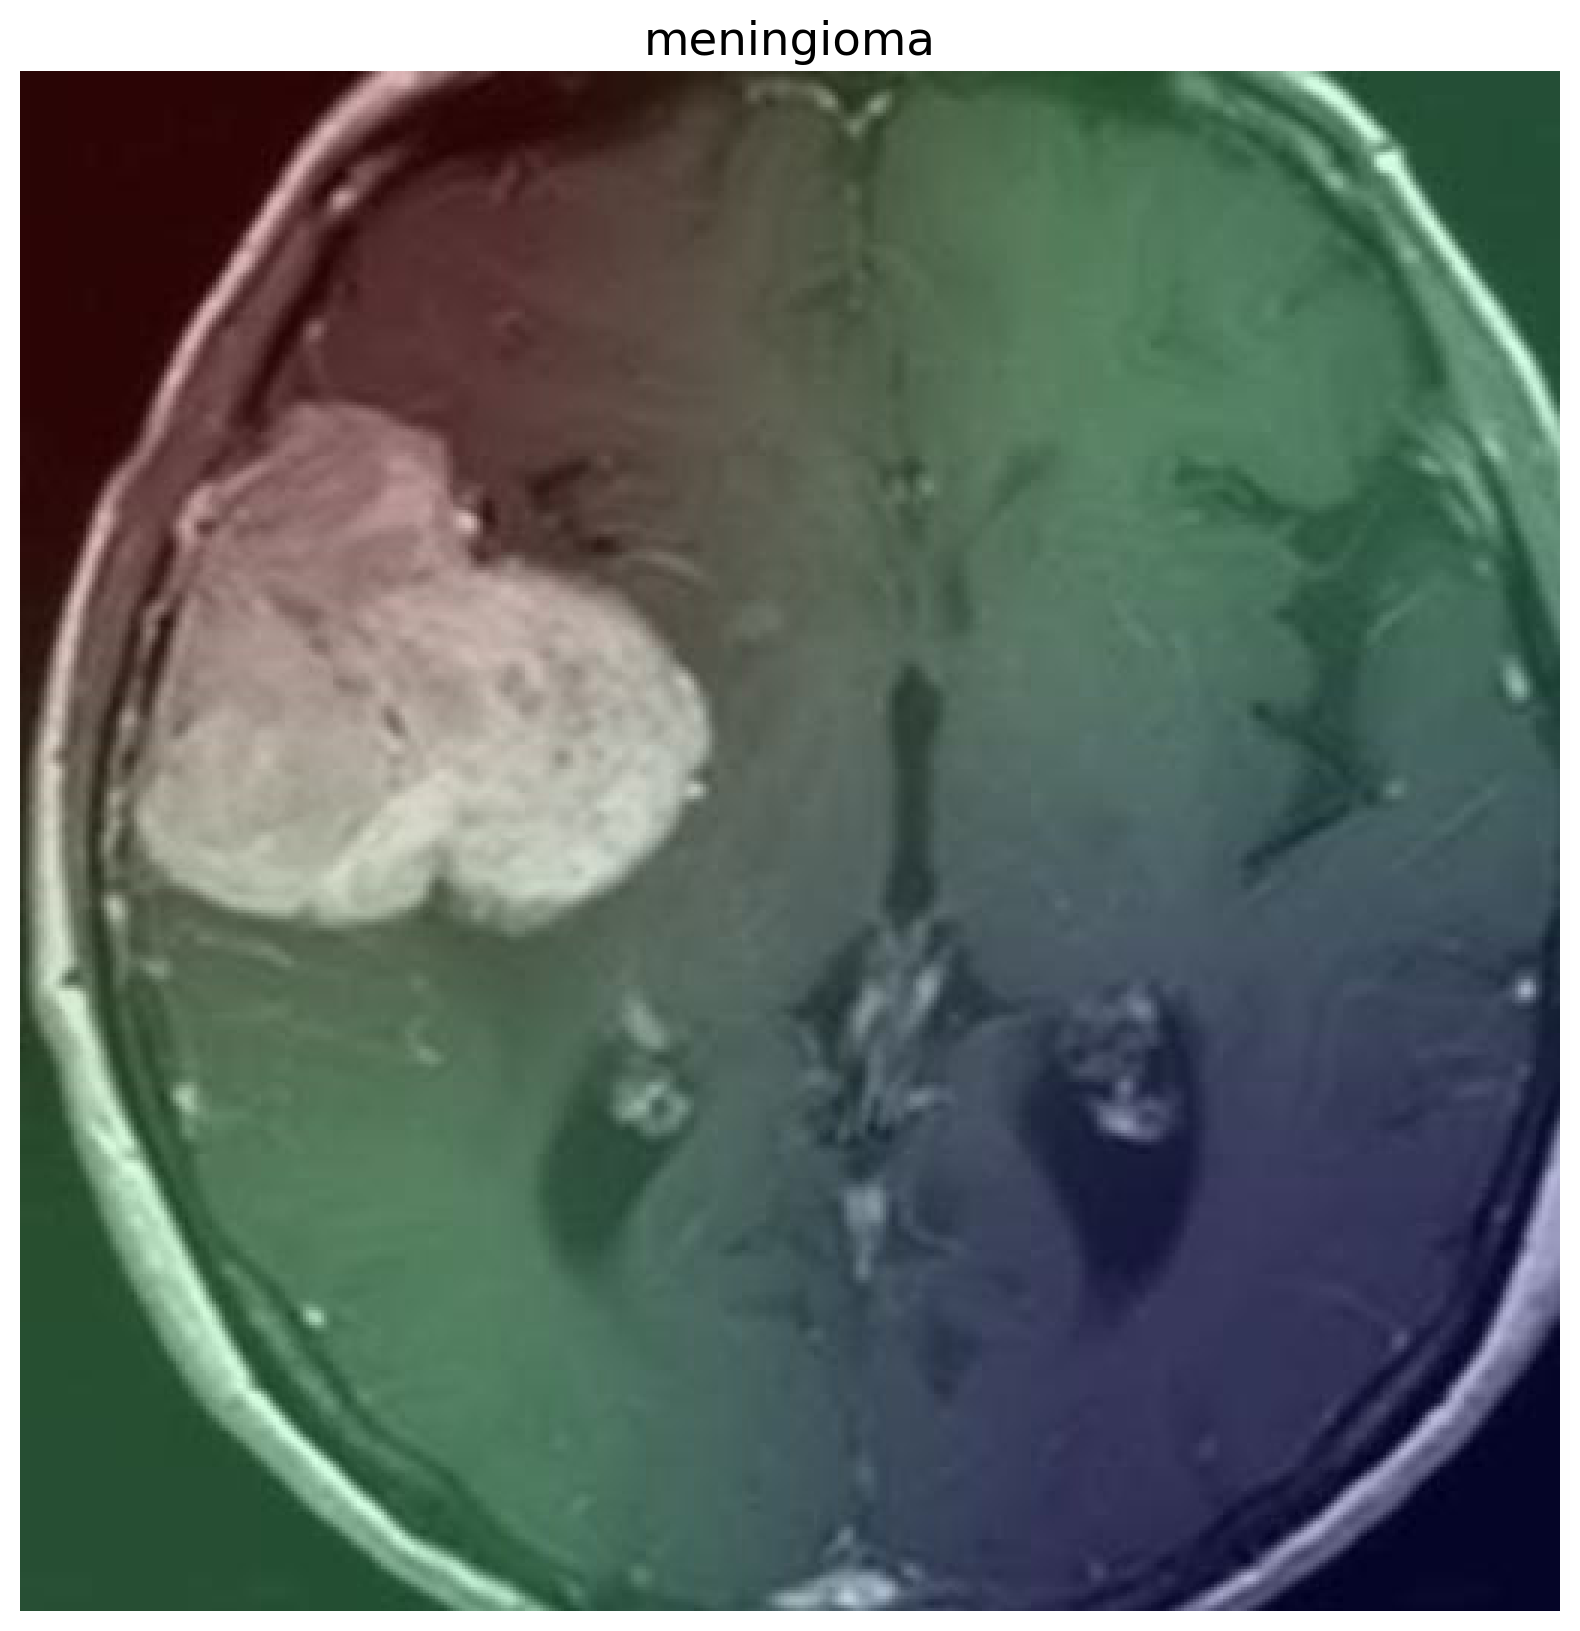

In [21]:
campath, prediction = make_prediction(r'C:\Users\jms\OneDrive\Desktop\Major 1\CodeBrain\models\decdata2\Testing\meningioma\Te-me_0025.jpg', campath="123.jpeg", view=False)
print(prediction)

test_img = img.imread(campath)
plt.imshow(test_img)
plt.title(prediction)
plt.axis("off")
plt.show()  # Display the plotted image


1/1 [==============================] - 0s 167ms/step


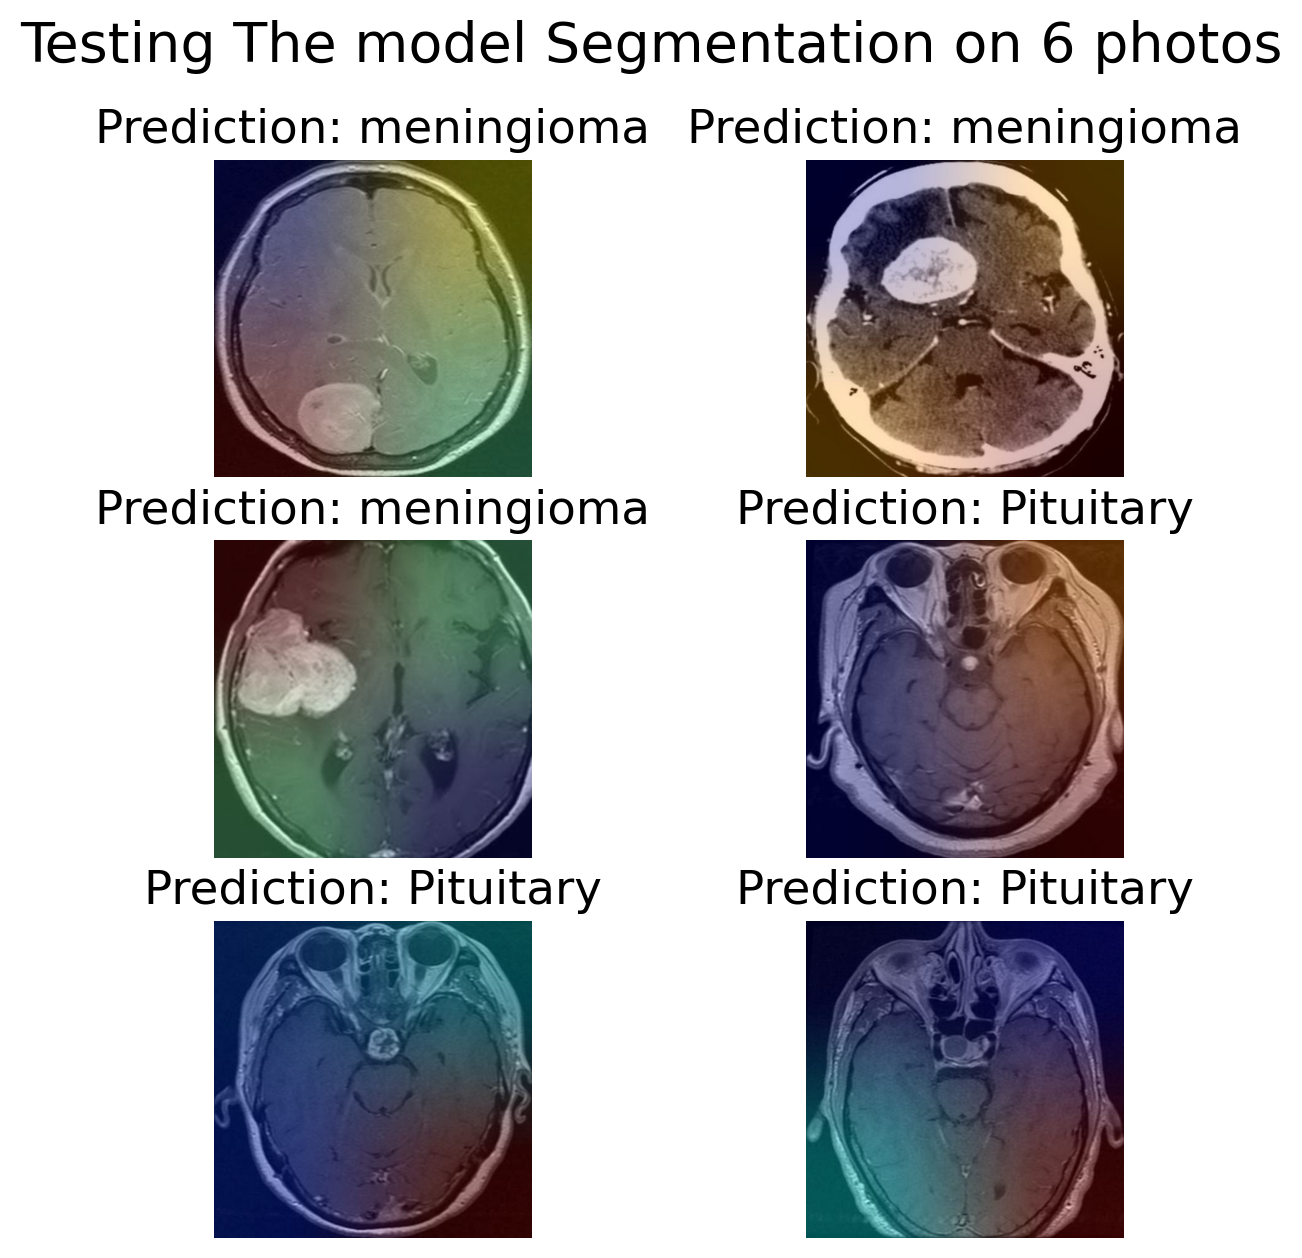

In [22]:
import matplotlib.pyplot as plt

# Define photos paths
path_array = [
    r'C:\Users\jms\OneDrive\Desktop\Major 1\CodeBrain\models\decdata2\Testing/meningioma/Te-me_0010.jpg',
    r'C:\Users\jms\OneDrive\Desktop\Major 1\CodeBrain\models\decdata2\Testing/meningioma/Te-me_0015.jpg',
    r'C:\Users\jms\OneDrive\Desktop\Major 1\CodeBrain\models\decdata2\Testing/meningioma/Te-me_0025.jpg',
    r'C:\Users\jms\OneDrive\Desktop\Major 1\CodeBrain\models\decdata2\Testing/pituitary/Te-pi_0010.jpg',
    r'C:\Users\jms\OneDrive\Desktop\Major 1\CodeBrain\models\decdata2\Testing/pituitary/Te-pi_0021.jpg',
    r'C:\Users\jms\OneDrive\Desktop\Major 1\CodeBrain\models\decdata2\Testing/pituitary/Te-pi_0030.jpg',
]

# Show predictions on 6 photos
fig = plt.figure(figsize=(7, 7))
fig.suptitle("Testing The model Segmentation on 6 photos", fontsize=20)

for i in range(6):
    ax = plt.subplot(3, 2, i + 1)
    campath, prediction = make_prediction(path_array[i], campath=f"{i}.jpeg")
    test_img = img.imread(campath)
    plt.imshow(test_img)
    plt.title("Prediction: " + prediction)
    plt.axis("off")


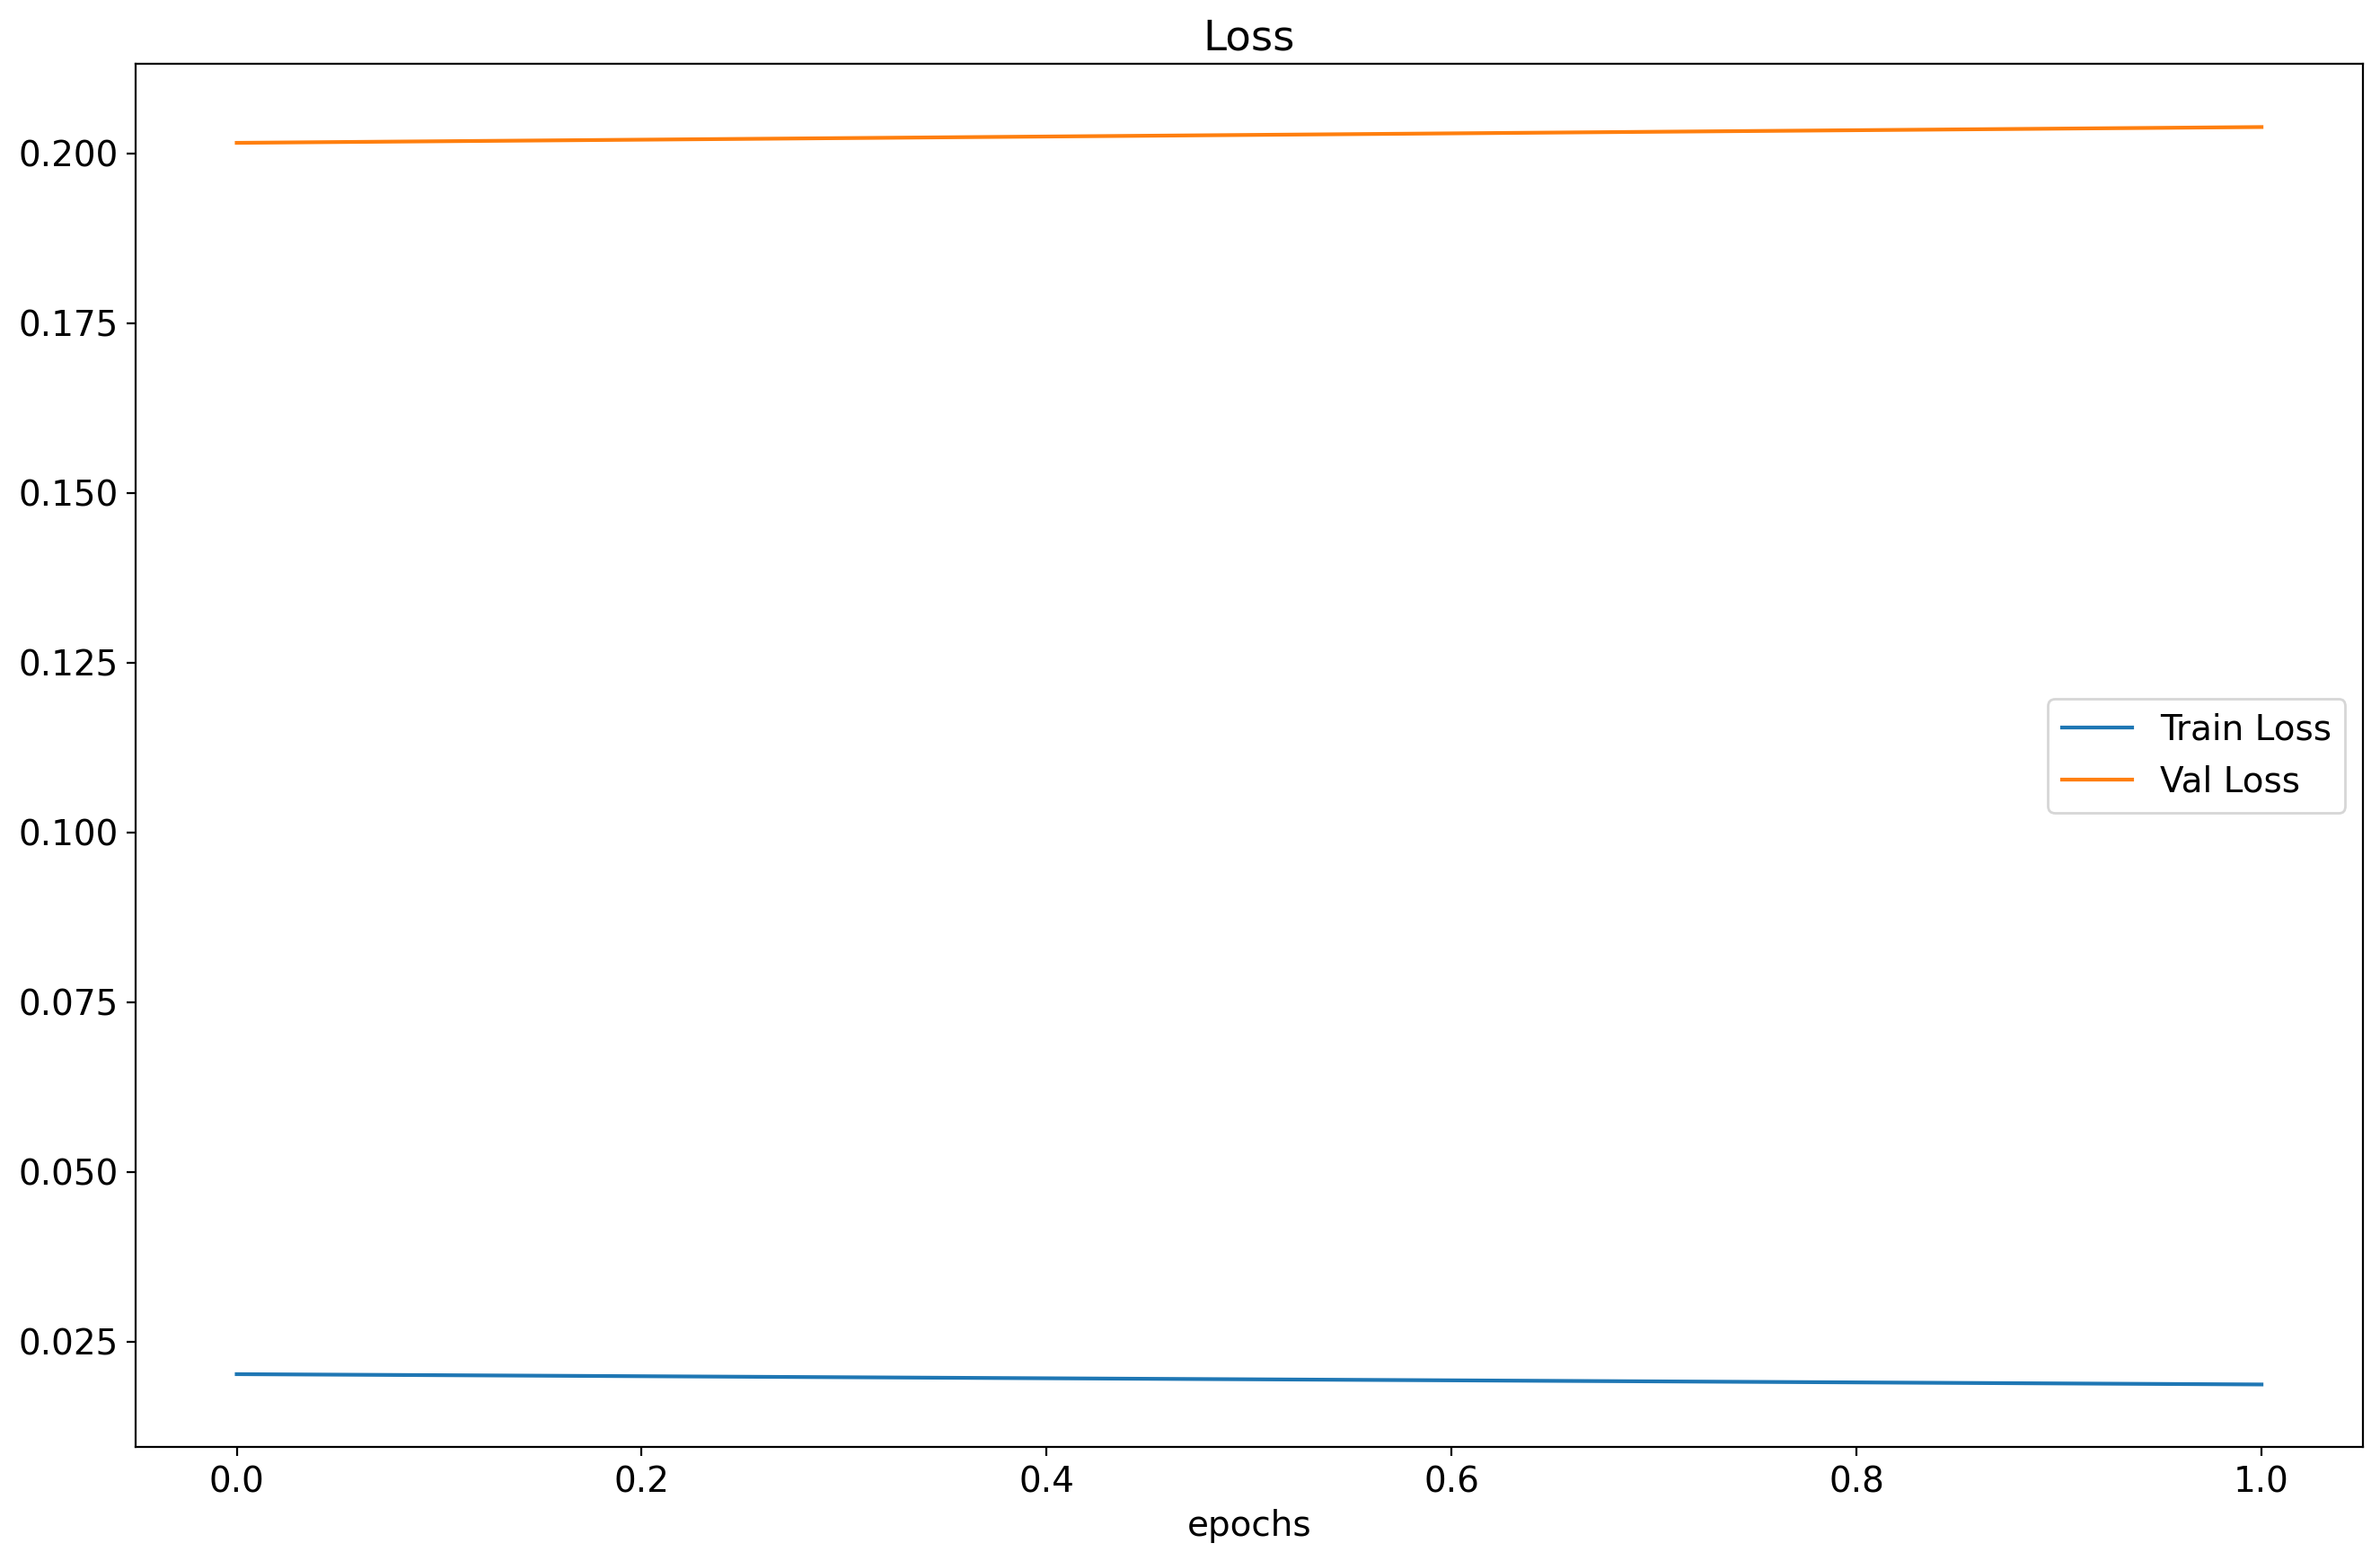

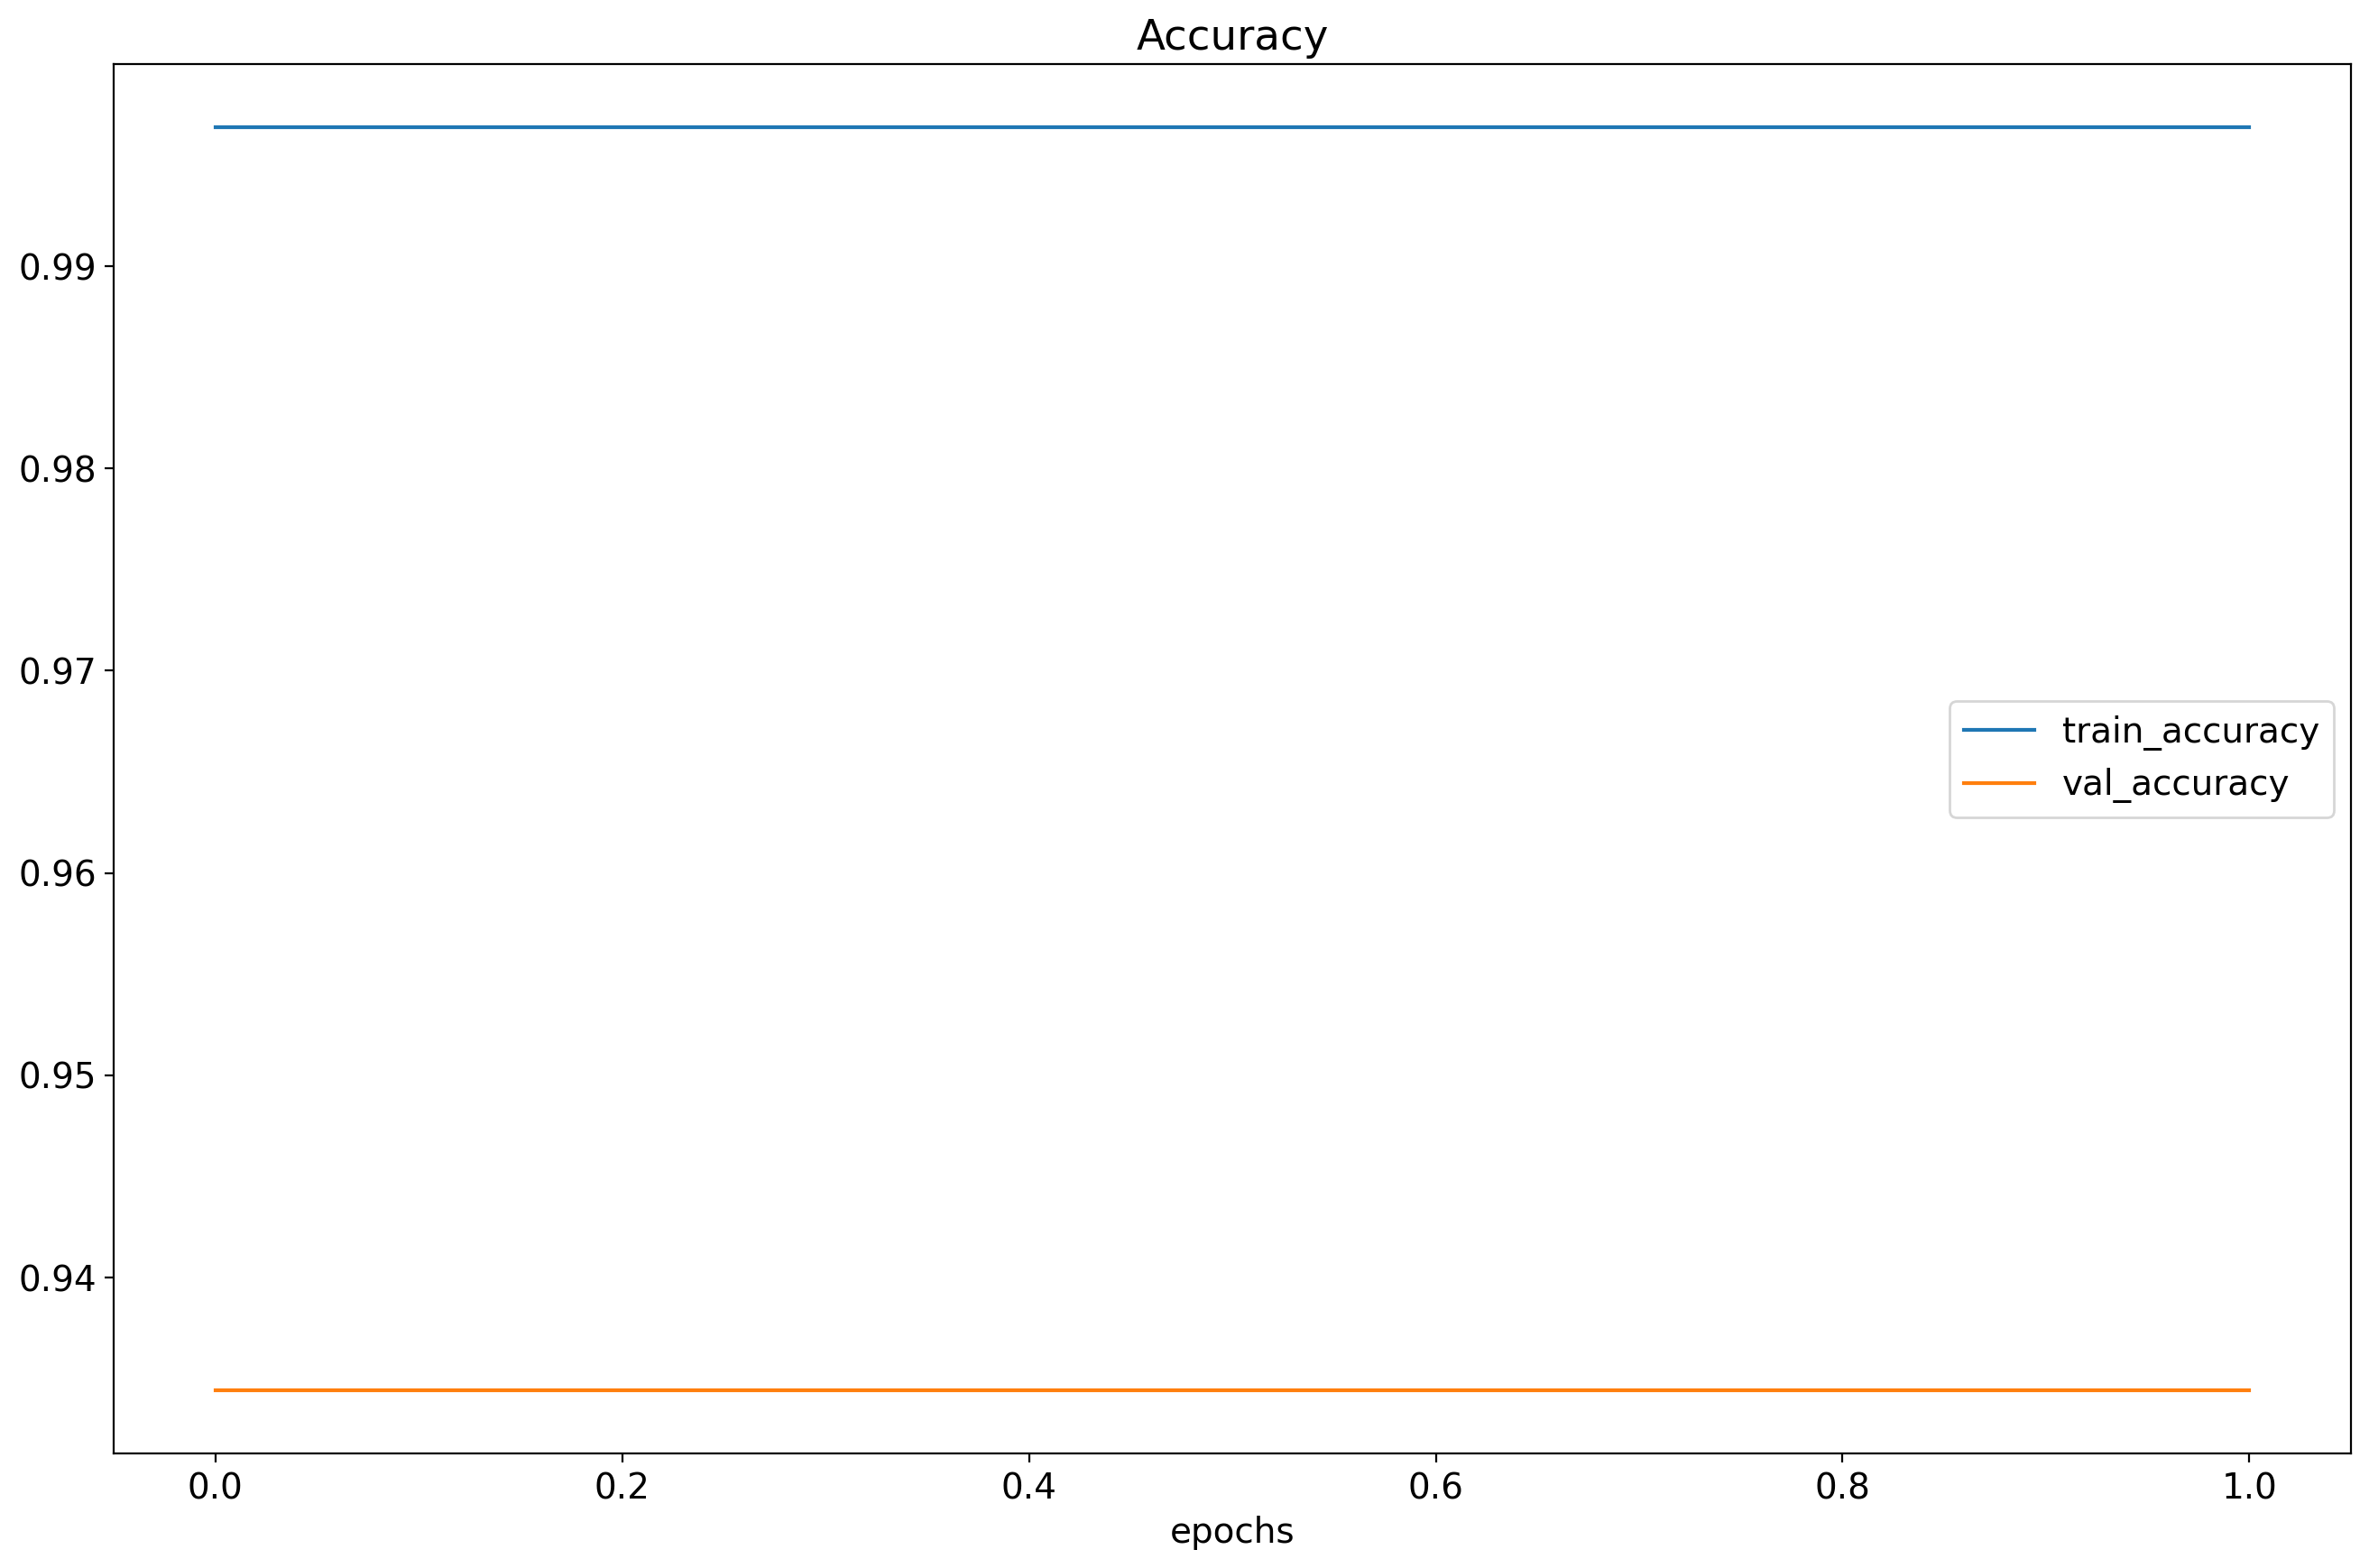

In [24]:
plot_loss_curves(Stage_2_history)